In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def shannon_diversity(group):
    proportions = group.value_counts(normalize=True)
    return -np.sum(proportions * np.log(proportions))

def generate_combined_visualizations(forest_df, grassland_df):
    # Add habitat column
    forest_df['Habitat'] = 'Forest'
    grassland_df['Habitat'] = 'Grassland'

    # Ensure date column is datetime
    forest_df['Date'] = pd.to_datetime(forest_df['Date'])
    grassland_df['Date'] = pd.to_datetime(grassland_df['Date'])

    # Keep only relevant columns
    common_cols = ['Date', 'Year', 'AOU_Code', 'Species', 'Temperature', 'Humidity', 'Habitat']
    common_cols = [col for col in common_cols if col in forest_df.columns and col in grassland_df.columns]
    forest_df = forest_df[common_cols]
    grassland_df = grassland_df[common_cols]

    # Combine datasets
    combined_df = pd.concat([forest_df, grassland_df], ignore_index=True)

    # Filter to keep only matching observations in both habitats
    paired_df = combined_df.groupby(['Date', 'AOU_Code']).filter(lambda x: x['Habitat'].nunique() == 2)
    # Merge the datasets
forest_df = pd.read_excel("C:/Users/sidde/Downloads/Bird_Monitoring_Data_FOREST.XLSX")
grassland_df = pd.read_excel("C:/Users/sidde/Downloads/Bird_Monitoring_Data_GRASSLAND.XLSX")

# Add habitat column
forest_df['Habitat'] = 'Forest'
grassland_df['Habitat'] = 'Grassland'

# Combine them
combined_df = pd.concat([forest_df, grassland_df], ignore_index=True)

# ---- STANDARDIZE SPECIES COLUMN ----
# Try to unify species identification column to "Species"
if 'Species' in paired_df.columns:
    pass  # already correct
elif 'Common_Name' in paired_df.columns:
    paired_df = paired_df.rename(columns={'Common_Name': 'Species'})
elif 'AOU_Code' in paired_df.columns:
    paired_df = paired_df.rename(columns={'AOU_Code': 'Species'})
else:
    raise KeyError("No species identification column found. Expected 'Species', 'Common_Name', or 'AOU_Code'.")




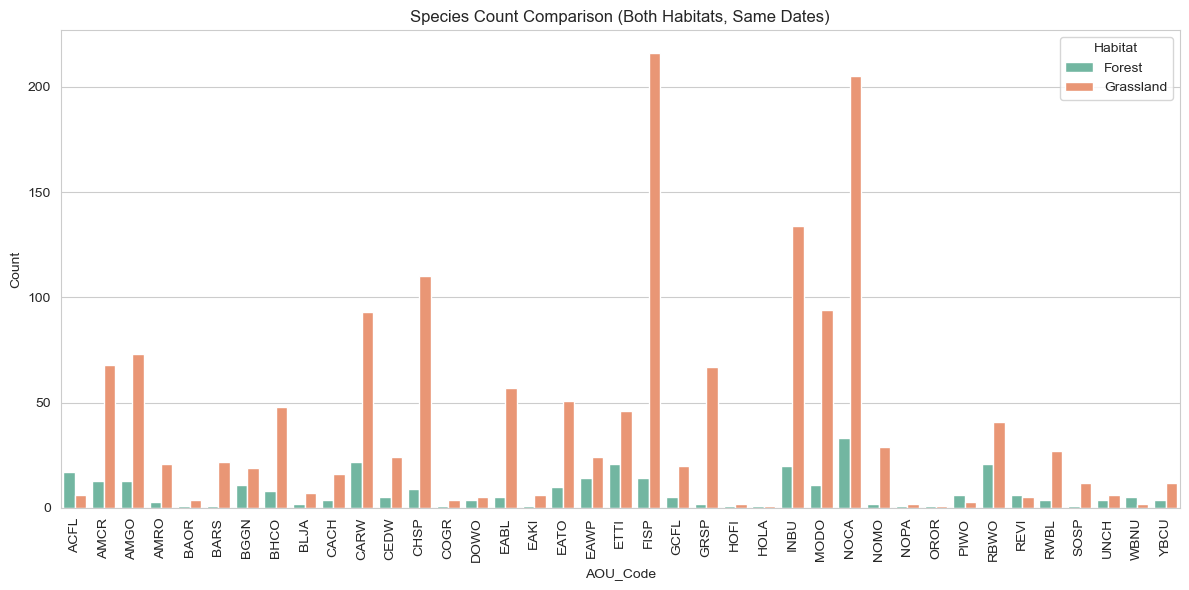

In [76]:
# 1. Species Count Comparison
species_counts = paired_df.groupby(['Habitat', 'AOU_Code']).size().reset_index(name='Count')
plt.figure(figsize=(12,6))
sns.barplot(data=species_counts, x='AOU_Code', y='Count', hue='Habitat')
plt.title("Species Count Comparison (Both Habitats, Same Dates)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

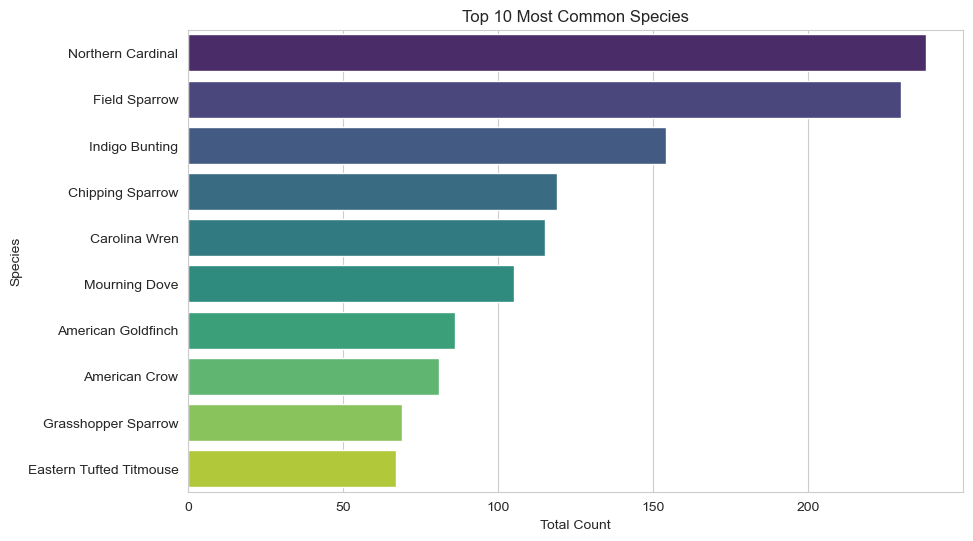

In [77]:
# Check available columns
cols = paired_df.columns

# Decide which column to use for grouping
if 'Species' in cols:
    species_col = 'Species'
elif 'Common_Name' in cols:
    species_col = 'Common_Name'
else:
    species_col = 'AOU_Code'  # Fallback

# Top 10 common species (or codes if names unavailable)
top_species = (
    paired_df.groupby(species_col)
    .size()
    .reset_index(name='TotalCount')
    .sort_values('TotalCount', ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_species,
    x='TotalCount',
    y=species_col,
    hue=species_col,           # assign colors per species
    palette='viridis',
    dodge=False                # keeps it as one bar per species
)
plt.title('Top 10 Most Common Species')
plt.xlabel('Total Count')
plt.ylabel(species_col)
plt.show()

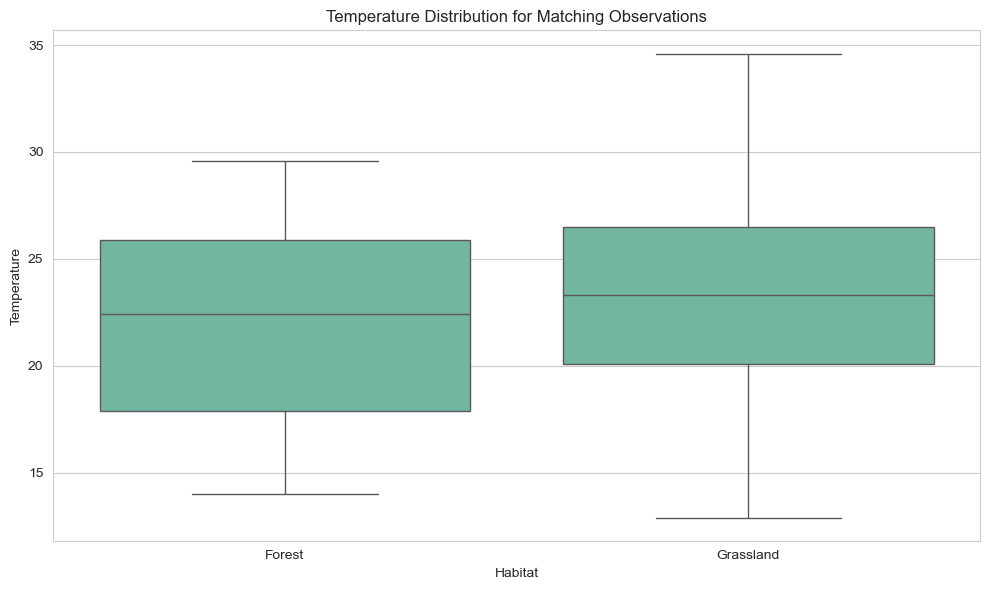

In [78]:
# 3. Temperature Comparison
plt.figure(figsize=(10,6))
sns.boxplot(data=paired_df, x='Habitat', y='Temperature')
plt.title("Temperature Distribution for Matching Observations")
plt.tight_layout()
plt.show()

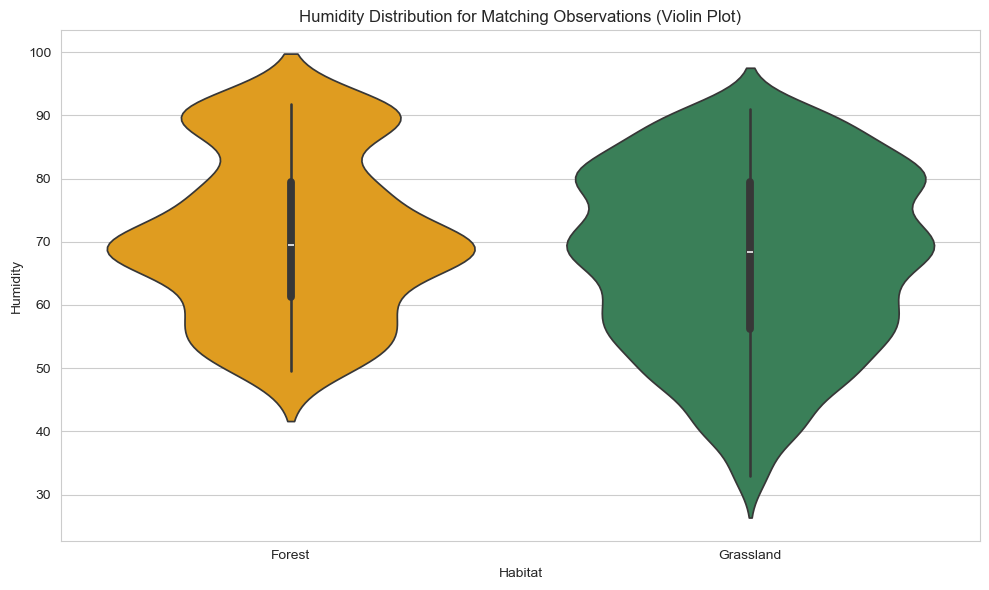

In [79]:
# 4. Humidity Comparison with custom colors (Future-proof, with actual categories)
plt.figure(figsize=(10,6))
sns.violinplot(
    data=paired_df,
    x='Habitat',
    y='Humidity',
    hue='Habitat',  
    palette={"Forest": "#FFA500", "Grassland": "#2E8B57"},  # match your real categories
    legend=False
)
plt.title("Humidity Distribution for Matching Observations (Violin Plot)")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

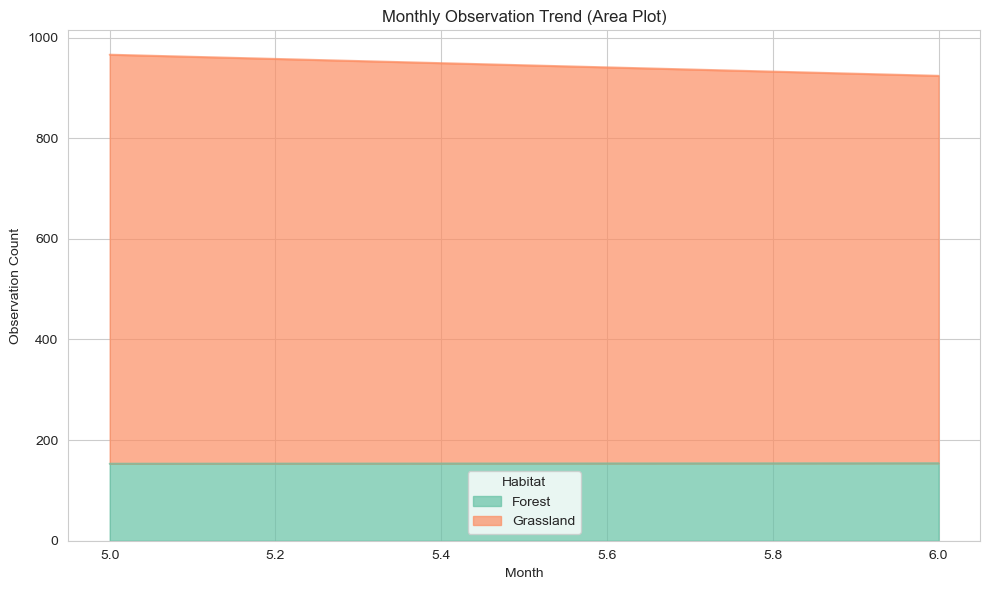

In [80]:
# 5. Monthly Observation Trend
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Pivot for area-style fill
monthly_pivot = monthly_counts.pivot(index='Month', columns='Habitat', values='Count')
monthly_pivot.plot(kind='area', alpha=0.7, figsize=(10,6))

plt.title("Monthly Observation Trend (Area Plot)")
plt.xlabel("Month")
plt.ylabel("Observation Count")
plt.tight_layout()
plt.show()




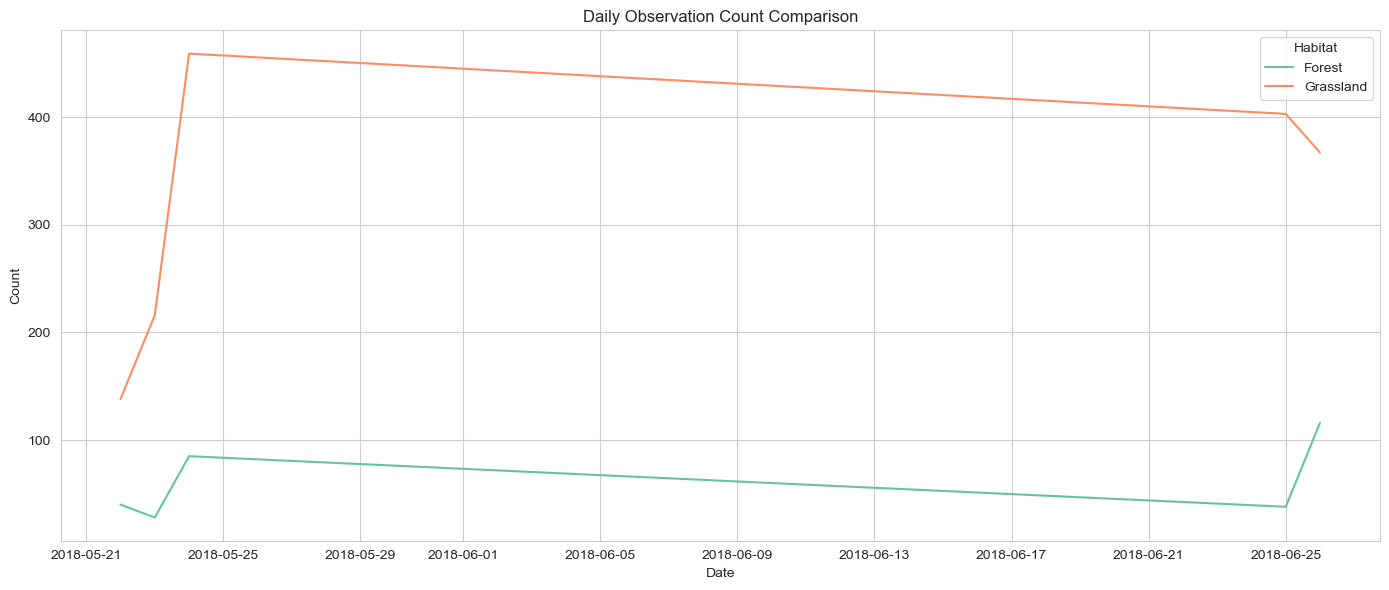

In [81]:
# 6. Daily Observation Count Comparison
daily_counts = paired_df.groupby(['Date', 'Habitat']).size().reset_index(name='Count')
plt.figure(figsize=(14,6))
sns.lineplot(data=daily_counts, x='Date', y='Count', hue='Habitat')
plt.title("Daily Observation Count Comparison")
plt.tight_layout()
plt.show()

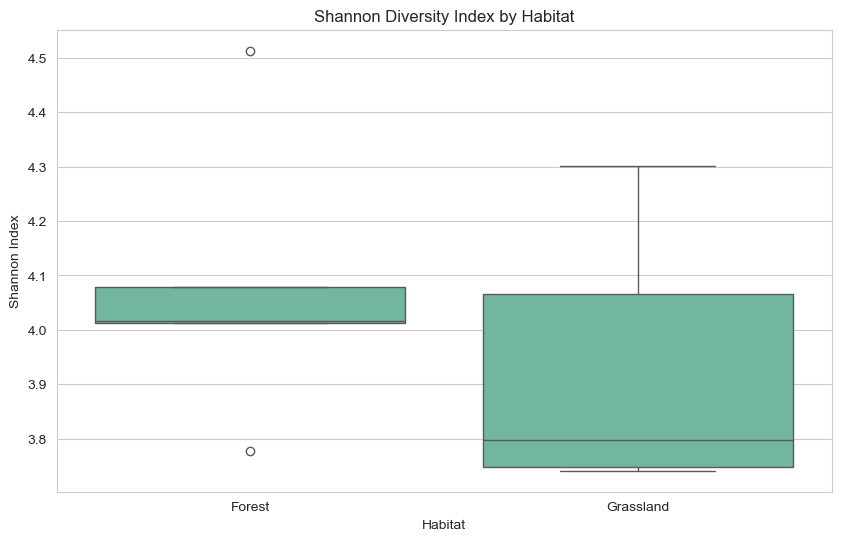

In [91]:
# Pick the species identifier column dynamically
cols = paired_df.columns
if 'Species' in cols:
    species_col = 'Species'
elif 'Common_Name' in cols:
    species_col = 'Common_Name'
else:
    species_col = 'AOU_Code'  # fallback to numeric code

#7. Shannon Diversity Function
from scipy.stats import entropy

def shannon_diversity(x):
    counts = x.value_counts()
    return entropy(counts, base=2)

# Calculate diversity
diversity = (
    paired_df.groupby(['Date','Habitat'])[species_col]
    .apply(shannon_diversity)
    .reset_index(name='ShannonIndex')
)

# Plot
plt.figure(figsize=(10,6))
sns.boxplot(data=diversity, x='Habitat', y='ShannonIndex')
plt.title('Shannon Diversity Index by Habitat')
plt.xlabel('Habitat')
plt.ylabel('Shannon Index')
plt.show()

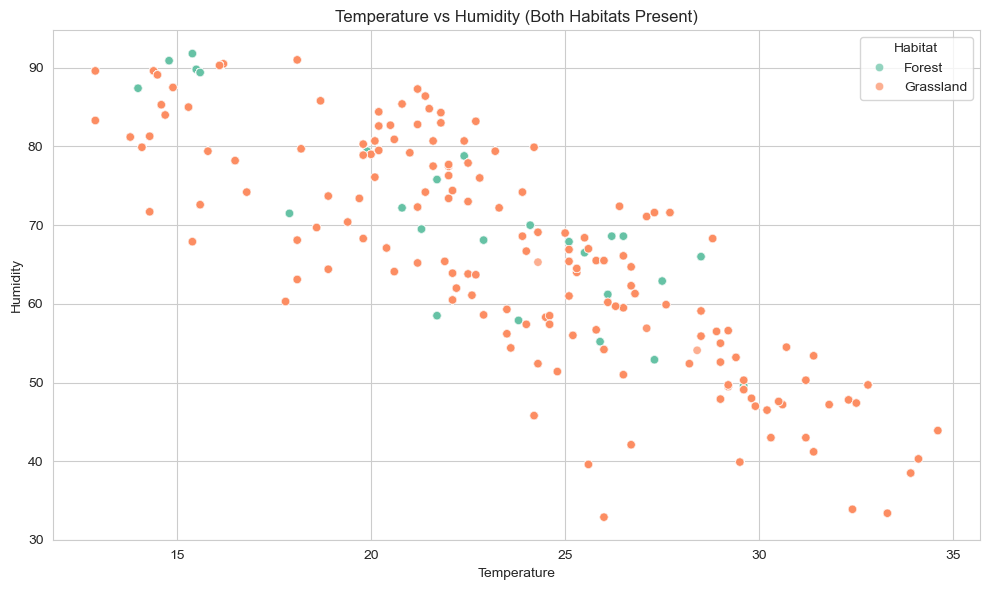

In [83]:
# 8. Temperature vs Humidity Scatter
plt.figure(figsize=(10,6))
sns.scatterplot(data=paired_df, x='Temperature', y='Humidity', hue='Habitat', alpha=0.7)
plt.title("Temperature vs Humidity (Both Habitats Present)")
plt.tight_layout()
plt.show()

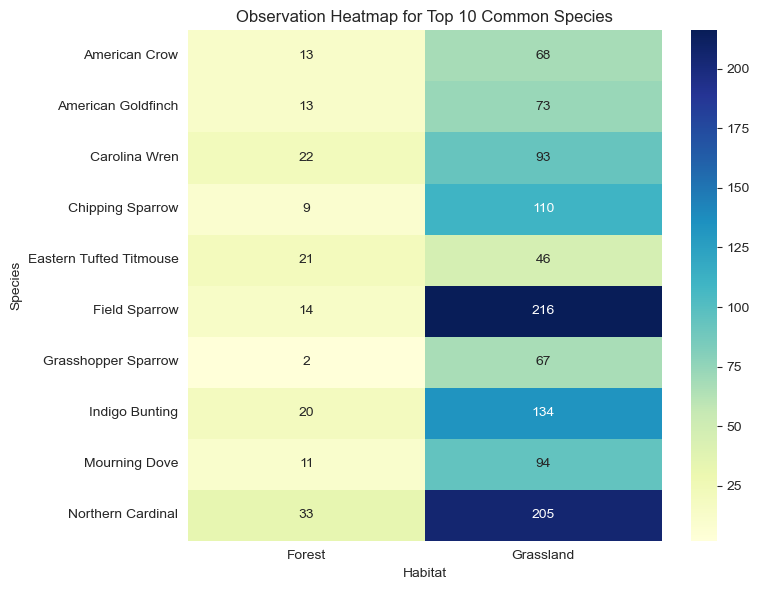

In [84]:
# 9. Heatmap for Top 10 Common Species
top_species_list = top_species['Species'].tolist()
heatmap_df = paired_df[paired_df['Species'].isin(top_species_list)]
heatmap_data = heatmap_df.groupby(['Species','Habitat']).size().unstack(fill_value=0)
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Observation Heatmap for Top 10 Common Species")
plt.tight_layout()
plt.show()

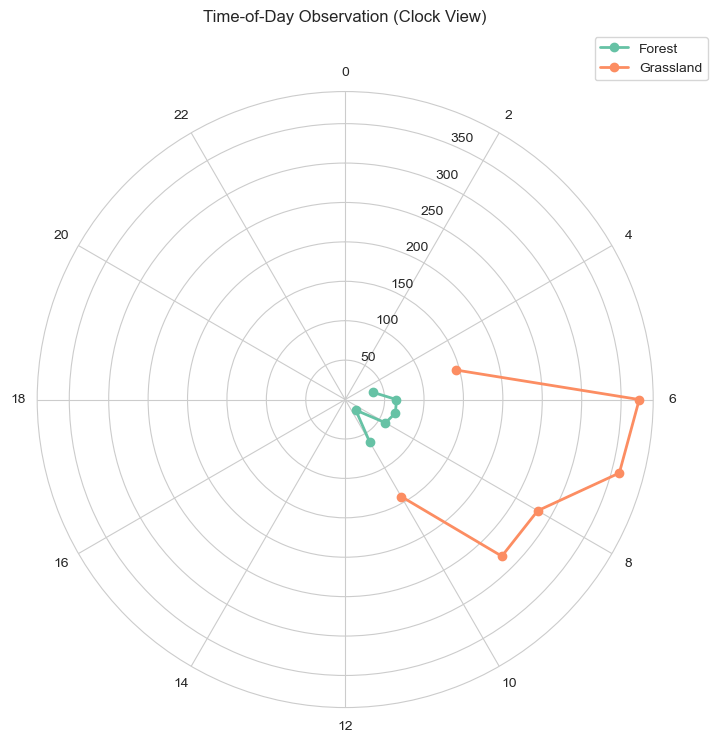

In [85]:
# 10. Time-of-Day Observation Comparison
import numpy as np

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for habitat in hourly_counts['Habitat'].unique():
    subset = hourly_counts[hourly_counts['Habitat'] == habitat]
    theta = np.deg2rad(subset['Hour'] * 15)  # 24 hours -> 360 degrees
    ax.plot(theta, subset['Count'], marker='o', label=habitat, linewidth=2)

ax.set_theta_direction(-1)  # Clockwise
ax.set_theta_offset(np.pi/2.0)  # Start at top
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))
ax.set_xticklabels(range(0, 24, 2))
ax.set_title("Time-of-Day Observation (Clock View)", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()
